In [1]:
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, PROJECT_ROOT)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from joblib import dump

from src.io_utils import load_df
from src.config import COLS, SEED
from src.eval_utils import compute_metrics, save_json, plot_confusion

In [3]:
X_TRAIN_PATH  = os.path.join(PROJECT_ROOT, "data/processed/X_train.csv")
Y_TRAIN_PATH  = os.path.join(PROJECT_ROOT, "data/processed/y_train.csv")
X_TEST_PATH   = os.path.join(PROJECT_ROOT, "data/processed/X_test.csv")
Y_TEST_PATH   = os.path.join(PROJECT_ROOT, "data/processed/y_test.csv")

MODEL_PATH    = os.path.join(PROJECT_ROOT, "models/xgb_classifier.pkl")
REPORTS_JSON  = os.path.join(PROJECT_ROOT, "reports/xgb_metrics.json")
FIG_CM_RAW    = os.path.join(PROJECT_ROOT, "figures/xgb_confusion_raw.png")
FIG_CM_NORM   = os.path.join(PROJECT_ROOT, "figures/xgb_confusion_norm.png")
FIG_FEAT_IMP  = os.path.join(PROJECT_ROOT, "figures/xgb_feature_importance_gain.png")

In [4]:
X_train = load_df(X_TRAIN_PATH)
y_train = load_df(Y_TRAIN_PATH)["Target"]
X_test  = load_df(X_TEST_PATH)
y_test  = load_df(Y_TEST_PATH)["Target"]

print("Train:", X_train.shape, " Test:", X_test.shape)
print("Train class ratio:\n", y_train.value_counts(normalize=True).round(3))
print("Test  class ratio:\n",  y_test.value_counts(normalize=True).round(3))

Train: (3539, 13)  Test: (885, 13)
Train class ratio:
 Target
2    0.499
0    0.321
1    0.179
Name: proportion, dtype: float64
Test  class ratio:
 Target
2    0.499
0    0.321
1    0.180
Name: proportion, dtype: float64


In [5]:
xgb = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    objective="multi:softprob",
    eval_metric="mlogloss",
    random_state=SEED,
    n_jobs=-1,
    tree_method="hist"  # fast, good default on CPU
)

xgb.fit(X_train, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [6]:
y_pred = xgb.predict(X_test)

label_names = ["Dropout", "Graduate", "Enrolled"]  # keep consistent with your encoding
labels = sorted(y_train.unique())

metrics = compute_metrics(y_test, y_pred, labels=labels, label_names=label_names)
print("Accuracy:", round(metrics["accuracy"], 4))
print(pd.DataFrame(metrics["per_class"]).T)

save_json(metrics, REPORTS_JSON)
print("Saved metrics ->", REPORTS_JSON)

Accuracy: 0.7401
          precision    recall        f1  support
Dropout    0.748175  0.721831  0.734767    284.0
Graduate   0.451852  0.383648  0.414966    159.0
Enrolled   0.817227  0.880090  0.847495    442.0
Saved metrics -> /home/glinux/Projects/Skole/AnvendtData/reports/xgb_metrics.json


Saved confusion matrices -> /home/glinux/Projects/Skole/AnvendtData/figures/xgb_confusion_raw.png  &  /home/glinux/Projects/Skole/AnvendtData/figures/xgb_confusion_norm.png


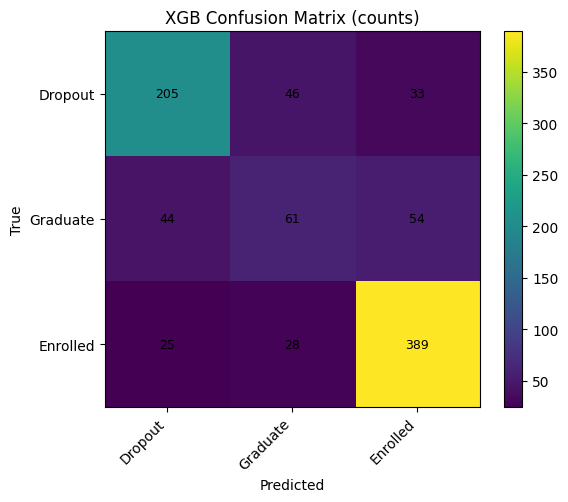

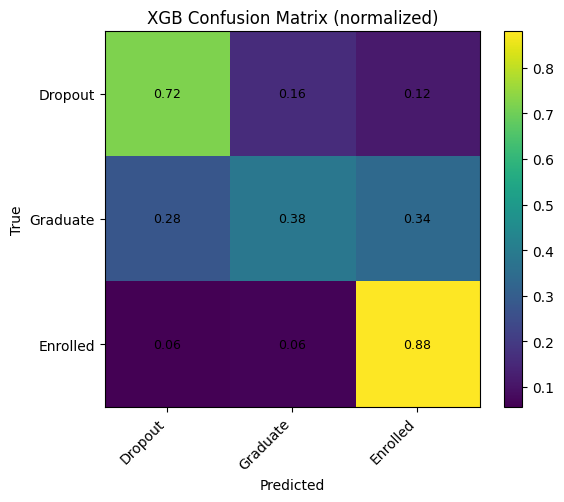

In [7]:
plot_confusion(y_test, y_pred, label_names=label_names, normalize=False,
               title="XGB Confusion Matrix (counts)", save_path=FIG_CM_RAW)
plot_confusion(y_test, y_pred, label_names=label_names, normalize=True,
               title="XGB Confusion Matrix (normalized)", save_path=FIG_CM_NORM)
print("Saved confusion matrices ->", FIG_CM_RAW, " & ", FIG_CM_NORM)

In [8]:
# Gain is more informative than default weight frequency
booster = xgb.get_booster()
gain_map = booster.get_score(importance_type="gain")  # dict: feature -> gain
# Map XGB feature names (f0, f1, ...) back to real column names
feat_names = {f"f{idx}": name for idx, name in enumerate(X_train.columns)}
gain_series = pd.Series({feat_names.get(k, k): v for k, v in gain_map.items()})
gain_series = gain_series.sort_values(ascending=True)

plt.figure(figsize=(7, 6))
gain_series.tail(15).plot(kind="barh")
plt.title("XGBoost — Top Feature Importance (Gain)")
plt.xlabel("Average Gain")
plt.tight_layout()
plt.savefig(FIG_FEAT_IMP, dpi=150, bbox_inches="tight")
plt.close()
print("Saved feature importance ->", FIG_FEAT_IMP)

Saved feature importance -> /home/glinux/Projects/Skole/AnvendtData/figures/xgb_feature_importance_gain.png


In [9]:
dump(xgb, MODEL_PATH)
print("Saved model ->", MODEL_PATH)

Saved model -> /home/glinux/Projects/Skole/AnvendtData/models/xgb_classifier.pkl
